<a href="https://colab.research.google.com/github/uyenphl/fetal-echocardiogram/blob/main/Main_fuzzy_ensemble_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/MasterThesis/Colab Model/Data/"
!unzip -q "/content/drive/MyDrive/MasterThesis/Colab Model/Data/Cardiac_General.zip"

'3class (normal, 4CV, 3VT).gdoc'   Cardiac_Original.zip
 Cardiac_General.zip		   output.csv


#Setup Libraries

In [3]:
import os
import glob
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn import model_selection
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_dir = '/content/Cardiac_General'
image_files = [os.path.join(data_dir, f)
for f in os.listdir(data_dir)
if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Extractor Baselearner

In [5]:
#Creating Frame
def createFrame(path,IMG_DIM):
  train_imgs = []
  labels = []
  directories = os.listdir(path)
  for i in range(len(directories)):
    ls = []
    temp = []
    curPath = path +'/' +directories[i] + '/*'
    ls = glob.glob(curPath)
    for img in ls:
      x = img_to_array(load_img(img,target_size = IMG_DIM))
      temp.append(x)

    train_imgs  = train_imgs + temp
    label = []
    label = [i]*len(ls)
    labels += label

  df = pd.DataFrame(list(zip(train_imgs,labels)))
  df = df.sample(frac = 1)
  return df

def kFold(df):

  df['kfold'] = -1
  df = df.reset_index(drop=True)
  y = df[1]
  kf = model_selection.StratifiedKFold(n_splits=5)
  for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,'kfold'] = f

  return df

#Customized CNN models
def DenseNet169(train_imgs,train_labels,class_no,num_epochs=10):
  print("--------------------------DenseNet-169--------------------------")
  input_shape_densenet = (224, 224, 3)
  densenet_model1 = keras.applications.DenseNet169(include_top=False,
                                                   weights="imagenet",
                                                   input_tensor=None,
                                                   input_shape=input_shape_densenet,
                                                   pooling=None)
  densenet_model1.trainable = True
  for layer in densenet_model1.layers:
    layer.trainable = False

  layer = keras.layers.Flatten()(densenet_model1.output)
  layer = keras.layers.Dense(units=512,activation='relu')(layer)
  layer = keras.layers.Dropout(0.2)(layer)
  layer = keras.layers.Dense(units=128,activation='relu')(layer)
  layer = keras.layers.Dense(units=class_no,activation='softmax')(layer)
  model1 = keras.models.Model(densenet_model1.input, outputs=layer)
  model1.compile(optimizer = keras.optimizers.RMSprop(learning_rate=2e-5),
                 loss='categorical_crossentropy',
                 metrics=['acc'])
  history = model1.fit(x=train_imgs,y=train_labels, epochs = num_epochs,
                       batch_size = 32, verbose=0, validation_split=0.2)
  print("----------------------------------------------------------------")
  return model1

def VGG16(train_imgs,train_labels,class_no,num_epochs=10):
  print("-----------------------------VGG16-----------------------------")
  pre_trained_model2 = keras.applications.VGG16(input_shape = (224,224,3),
                                                include_top=False,weights="imagenet")
  for layer in pre_trained_model2.layers:
    layer.trainable = False
  x = keras.layers.Flatten()(pre_trained_model2.output)
  x = layers.Dense(1024,activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(64,activation='relu')(x)
  x = layers.Dense(class_no,activation='softmax')(x)
  model2 = Model(pre_trained_model2.input,x)
  model2.compile(optimizer = RMSprop(learning_rate=2e-5),
                 loss='categorical_crossentropy',
                 metrics=['acc'])
  history = model2.fit(x=train_imgs,y=train_labels, epochs = num_epochs,
                       batch_size = 32, verbose=0, validation_split=0.2)
  print("----------------------------------------------------------------")
  return model2

def Xception(train_imgs,train_labels,class_no,num_epochs=10):
  print("----------------------------XCEPTION----------------------------")
  pre_trained_model3 = keras.applications.Xception(input_shape = (224,224,3),
                                                   include_top=False,weights="imagenet")
  for layer in pre_trained_model3.layers:
    layer.trainable = False
  x = keras.layers.Flatten()(pre_trained_model3.output)
  x = layers.Dense(102,activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(32,activation='relu')(x)
  x = layers.Dense(class_no,activation='softmax')(x)
  model3 = Model(pre_trained_model3.input,x)
  model3.compile(optimizer = RMSprop(learning_rate=2e-5),
                 loss='categorical_crossentropy',
                 metrics=['acc'])
  history = model3.fit(x=train_imgs,y=train_labels, epochs = num_epochs,
                       batch_size = 32, verbose=0, validation_split=0.2)
  print("----------------------------------------------------------------")
  return model3





# Generate Fuzzy Score

In [6]:
#Fuzzy Rank-based Ensemble:
def getScore(model,test_imgs):
  res = model.predict(test_imgs)
  return res

def generateRank1(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.exp(-((scores[i]-1)**2)/2.0)
  return rank

def generateRank2(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.tanh(((scores[i]-1)**2)/2)
  return rank

def generateRank3(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1/(1+(np.exp(-scores[i])))
  return rank

def doFusion(res1,res2,res3,label,class_no):
  cnt = 0
  id = []
  print(class_no)
  for i in range(len(res1)):
      rank1 = generateRank1(res1[i],class_no) * generateRank2(res1[i],class_no) * generateRank3(res1[i], class_no)
      rank2 = generateRank1(res2[i],class_no) * generateRank2(res2[i],class_no) * generateRank3(res2[i], class_no)
      rank3 = generateRank1(res3[i],class_no) * generateRank2(res3[i],class_no) * generateRank3(res3[i], class_no)
      rankSum = rank1 + rank2 + rank3
      rankSum = np.array(rankSum)
      scoreSum = 1 - (res1[i] + res2[i] + res3[i])/3
      scoreSum = np.array(scoreSum)

      fusedScore = (rankSum.T)*scoreSum
      cls = np.argmin(rankSum)
      if cls<class_no and label[i][cls]== 1:
          cnt += 1
      id.append(cls)
  print("doFusion Score")
  print(cnt/len(res1))
  return id



# Fuzzy Ensemble

----------------------------------------------------FOLD NO 0-------------------------------------------------------
--------------------------DenseNet-169--------------------------
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
----------------------------------------------------------------
-----------------------------VGG16-----------------------------
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
----------------------------------------------------------------
----------------------------XCEPTION----------------------------
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
----------------------------------------------------------------
BASE LEARNERS ACCURACY-----------1.DenseNet169 2.VGG16 3.Xception
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9470 - loss: 0.1267
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - acc: 0.9664 - loss: 0.1507
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.9627 - loss: 0.1264
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3

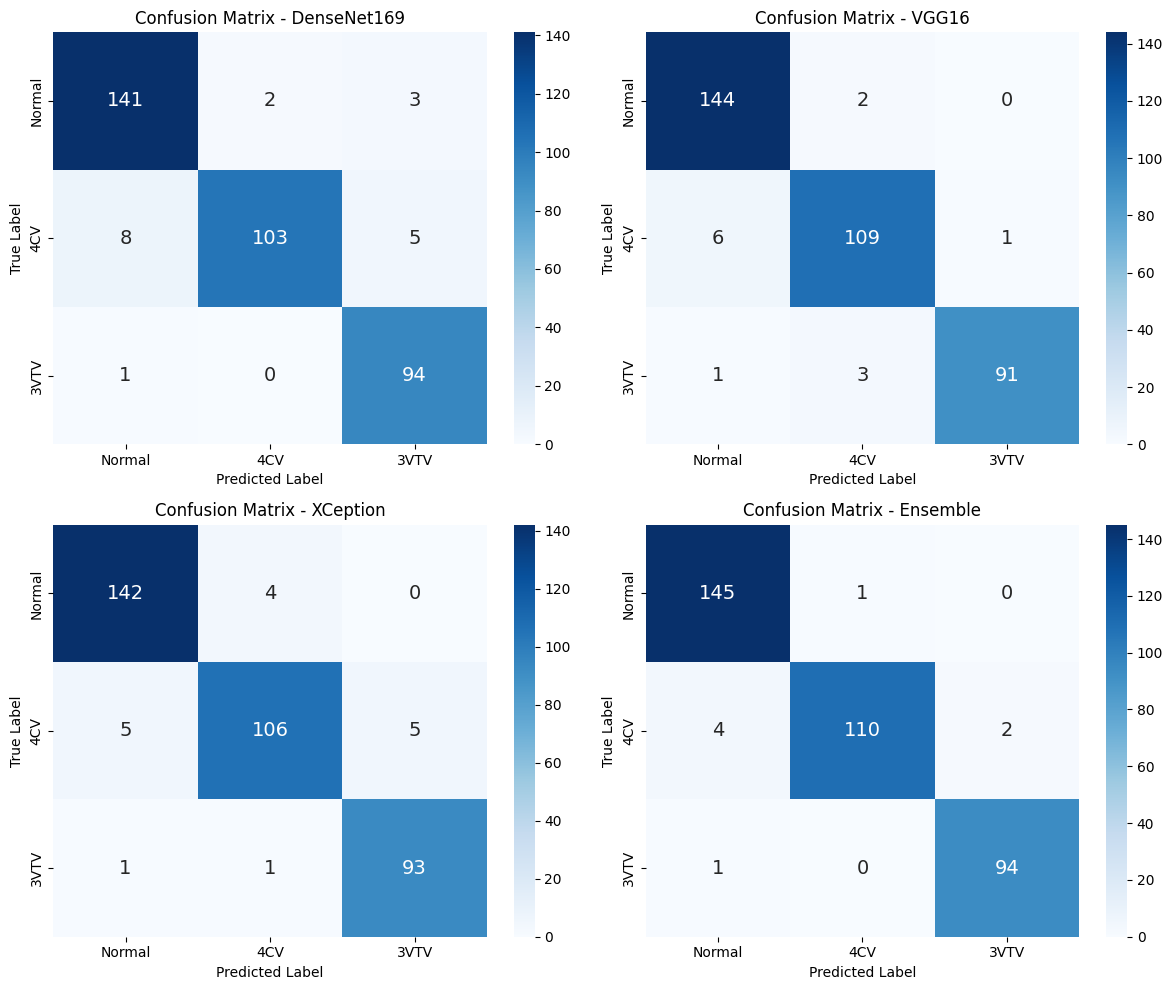

--------------------------------------------------END OF FOLD NO 0--------------------------------------------------------
----------------------------------------------------FOLD NO 1-------------------------------------------------------
--------------------------DenseNet-169--------------------------
----------------------------------------------------------------
-----------------------------VGG16-----------------------------
----------------------------------------------------------------
----------------------------XCEPTION----------------------------
----------------------------------------------------------------
BASE LEARNERS ACCURACY-----------1.DenseNet169 2.VGG16 3.Xception
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.9483 - loss: 0.1310
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - acc: 0.9142 - loss: 0.2222
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9529 - loss: 0.1559
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
12/12 ━━━━━━━━━━━━━━━━━

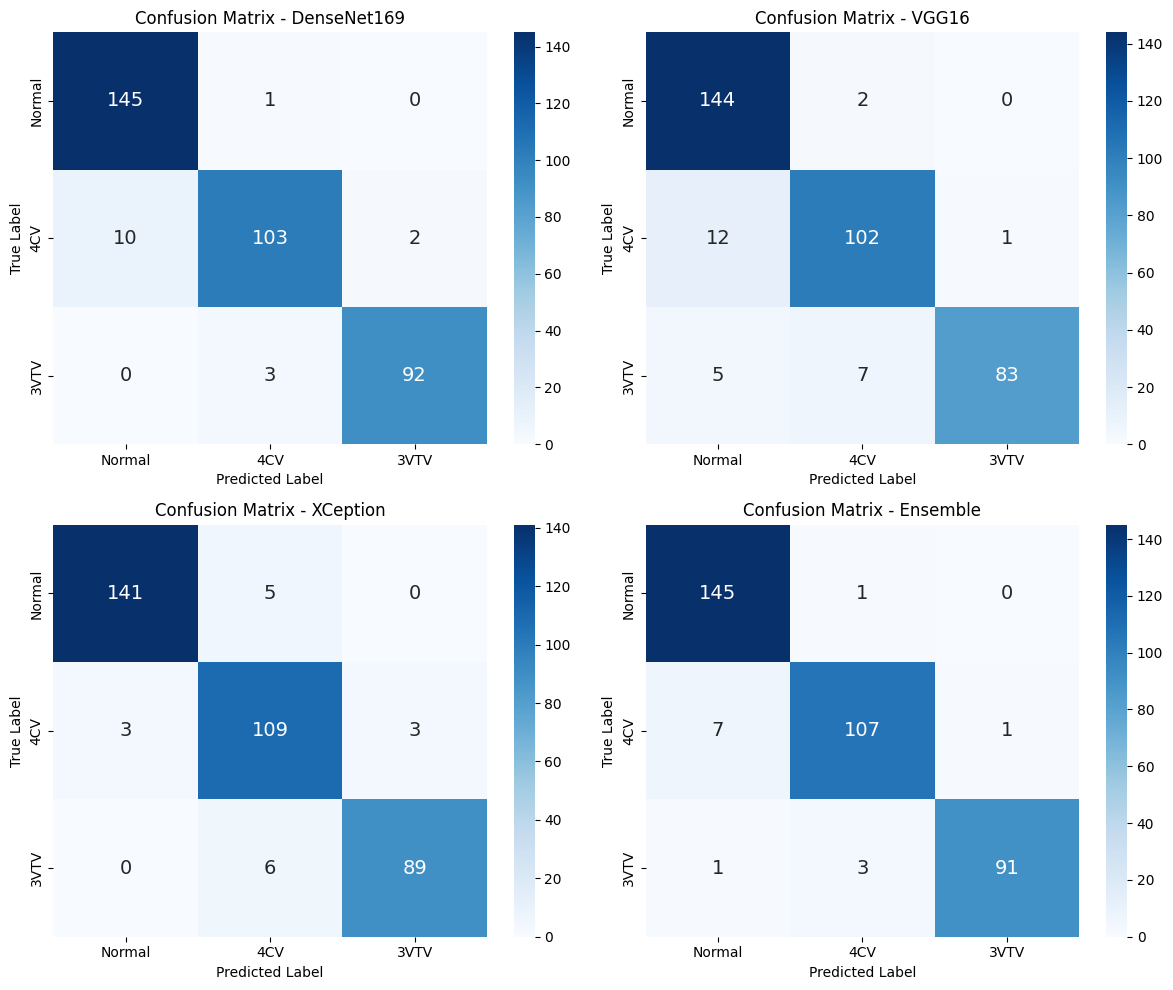

--------------------------------------------------END OF FOLD NO 1--------------------------------------------------------
----------------------------------------------------FOLD NO 2-------------------------------------------------------
--------------------------DenseNet-169--------------------------
----------------------------------------------------------------
-----------------------------VGG16-----------------------------
----------------------------------------------------------------
----------------------------XCEPTION----------------------------
----------------------------------------------------------------
BASE LEARNERS ACCURACY-----------1.DenseNet169 2.VGG16 3.Xception
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9501 - loss: 0.1272
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - acc: 0.9527 - loss: 0.1405
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.9496 - loss: 0.1691
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
12/12 ━━━━━━━━━━━━━━━━━

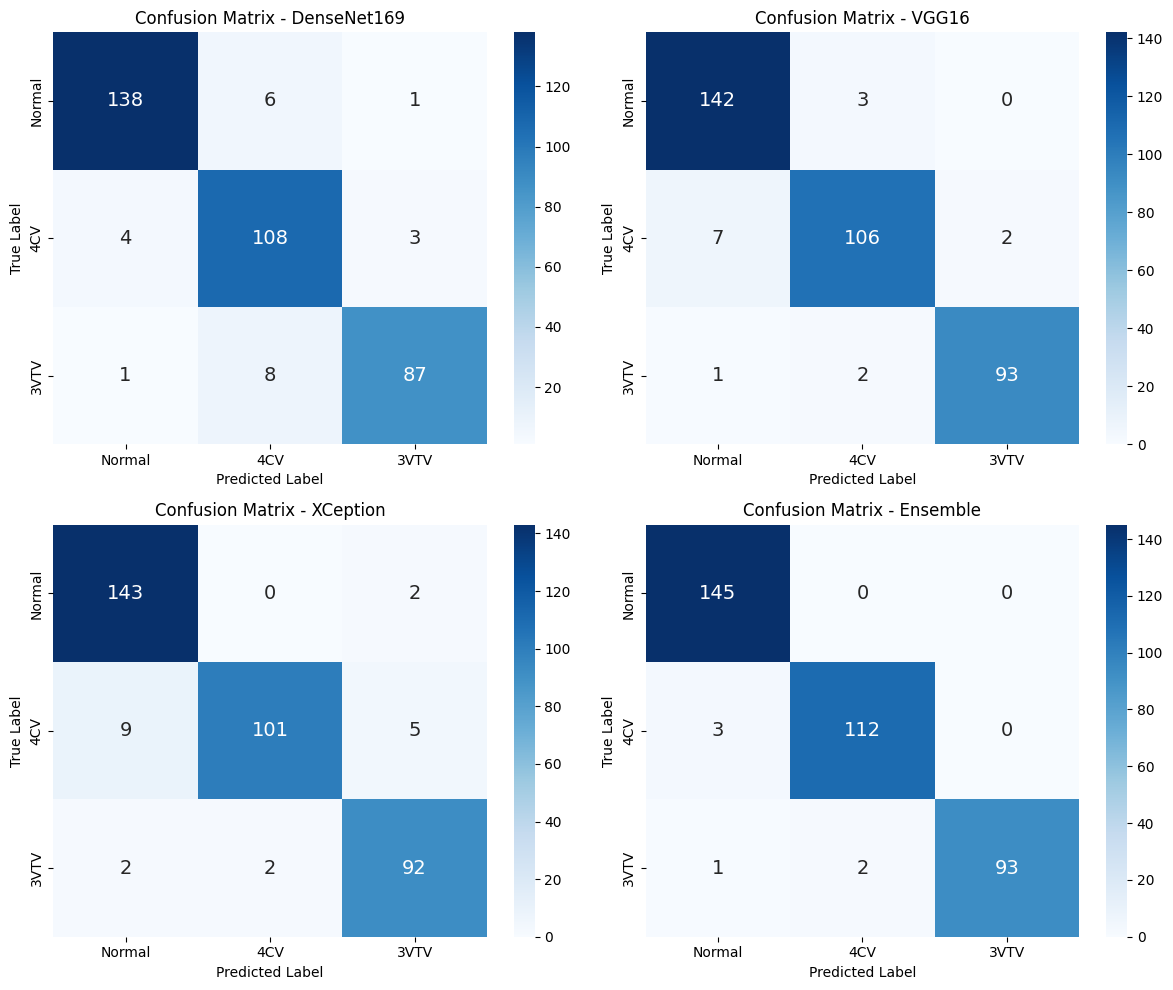

--------------------------------------------------END OF FOLD NO 2--------------------------------------------------------
----------------------------------------------------FOLD NO 3-------------------------------------------------------
--------------------------DenseNet-169--------------------------
----------------------------------------------------------------
-----------------------------VGG16-----------------------------
----------------------------------------------------------------
----------------------------XCEPTION----------------------------
----------------------------------------------------------------
BASE LEARNERS ACCURACY-----------1.DenseNet169 2.VGG16 3.Xception
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9689 - loss: 0.0891
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - acc: 0.9604 - loss: 0.1445
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.9322 - loss: 0.1528
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
12/12 ━━━━━━━━━━━━━━━━━

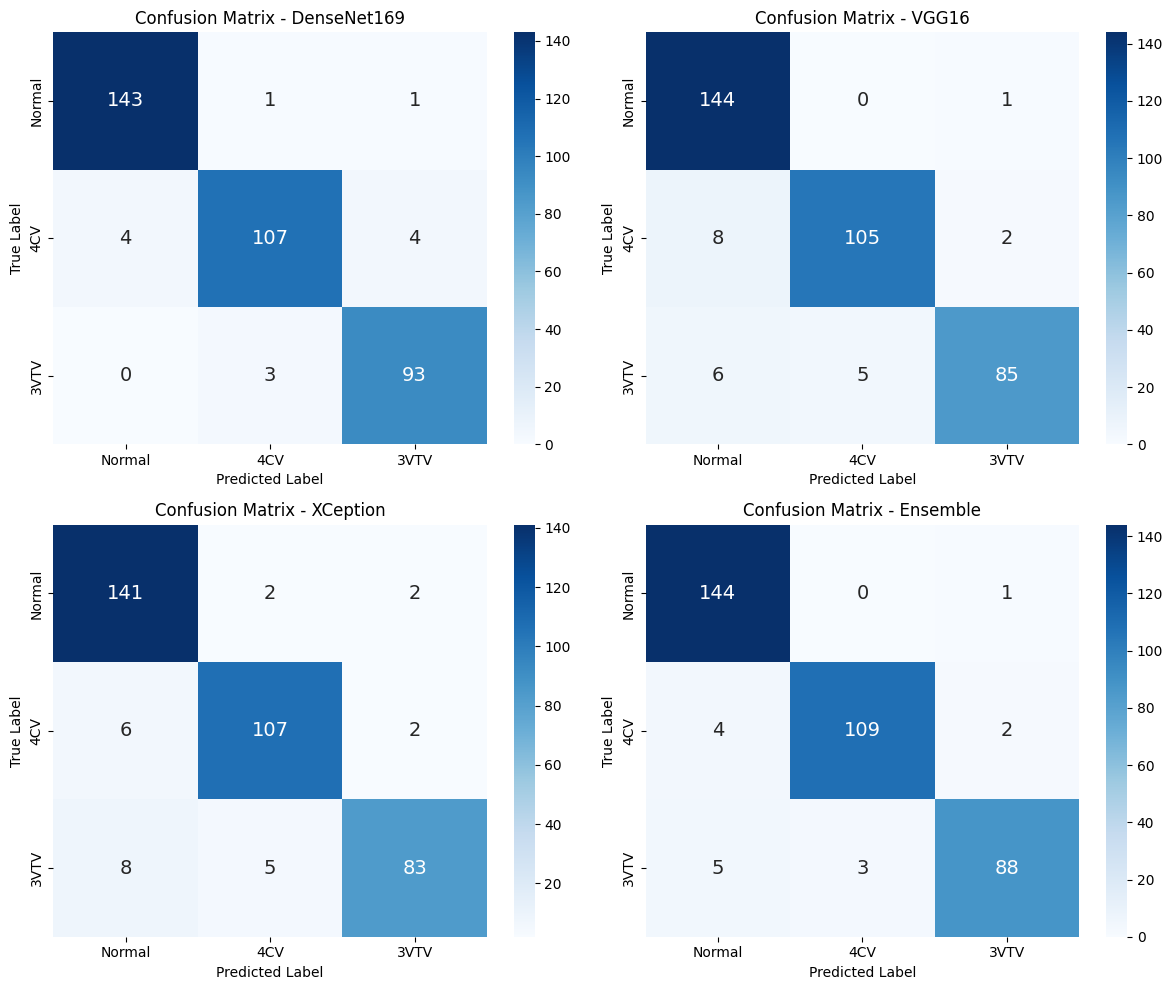

--------------------------------------------------END OF FOLD NO 3--------------------------------------------------------
----------------------------------------------------FOLD NO 4-------------------------------------------------------
--------------------------DenseNet-169--------------------------
----------------------------------------------------------------
-----------------------------VGG16-----------------------------
----------------------------------------------------------------
----------------------------XCEPTION----------------------------
----------------------------------------------------------------
BASE LEARNERS ACCURACY-----------1.DenseNet169 2.VGG16 3.Xception
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9705 - loss: 0.1173
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - acc: 0.9567 - loss: 0.1510
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.9345 - loss: 0.2001
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
12/12 ━━━━━━━━━━━━━━━━━

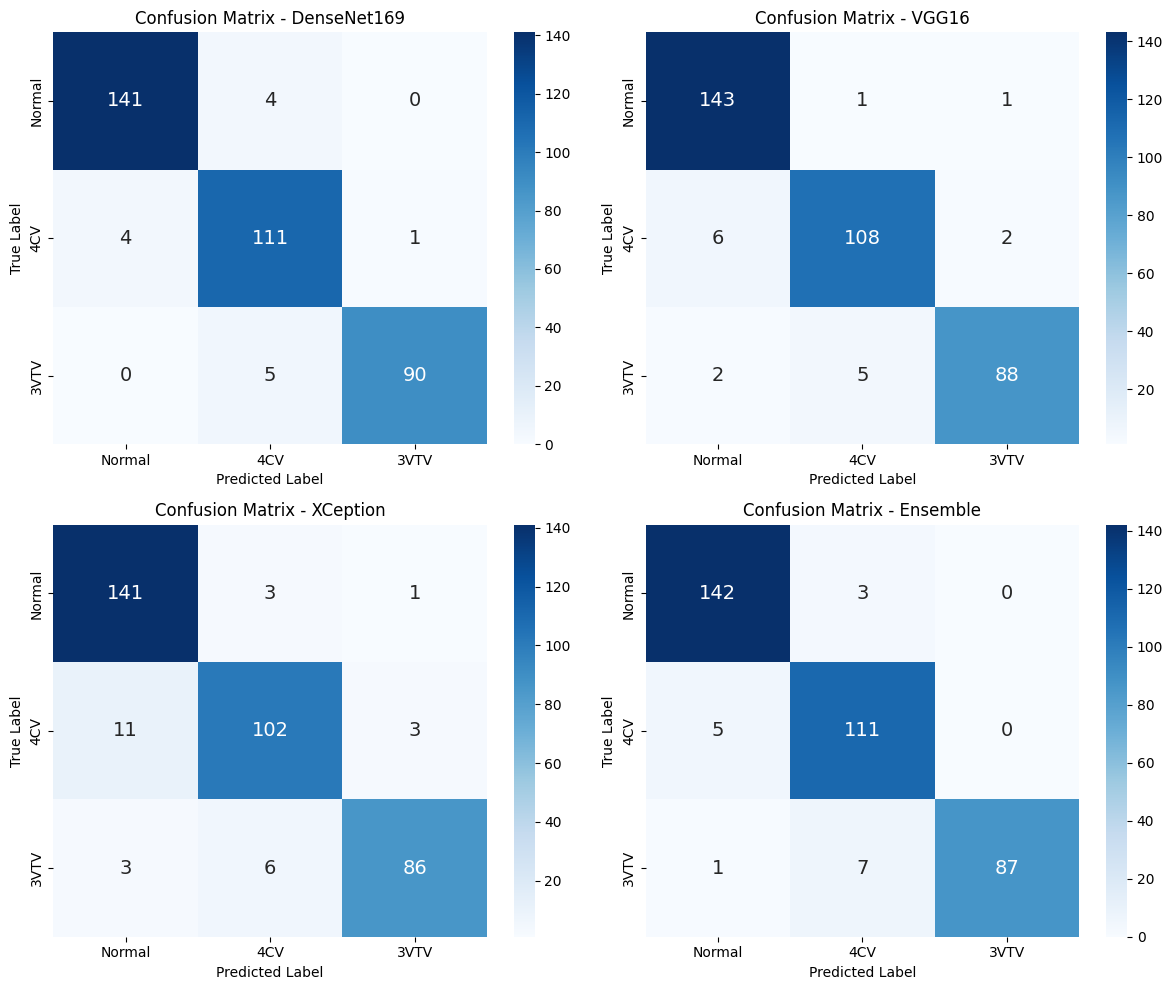

--------------------------------------------------END OF FOLD NO 4--------------------------------------------------------


In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_directory', type=str, default = '.', help='Directory where the image data is stored')
parser.add_argument('--epochs', type=int, default = 10, help='Number of Epochs of training')

args = parser.parse_args(['--data_directory', '/content/Cardiac_General', '--epochs', '10'])

path1 = args.data_directory
num_epochs = args.epochs

IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT,3)

df = createFrame(path1,IMG_DIM)
df = kFold(df)

target_names = os.listdir(path1)
num_classes = len(target_names)

best_accuracy = 0
best_fold_index = -1
best_model1 = None
best_model2 = None
best_model3 = None

for i in range(5):
  print(f"----------------------------------------------------FOLD NO {i}-------------------------------------------------------")
  dfTrain = df[df['kfold']!=i]
  dfTest = df[(df['kfold']==i)]

  # Check if the test DataFrame is empty
  if dfTest.empty:
    print(f"Skipping fold {i} due to empty test set.")
    continue

  train_imgs = list(dfTrain[0])
  train_imgs = np.array(train_imgs)
  train_imgs = train_imgs/255
  train_labels = np.array(dfTrain[1])
  encoder = LabelEncoder()
  encoder.fit(train_labels)
  train_labels = encoder.transform(train_labels)
  train_labels = to_categorical(train_labels)

  test_imgs = list(dfTest[0])
  test_imgs = np.array(test_imgs)
  test_imgs = test_imgs/255
  test_labels = np.array(dfTest[1])
  encoder = LabelEncoder()
  encoder.fit(test_labels)
  test_labels = encoder.transform(test_labels)
  test_labels = to_categorical(test_labels)

  # Define target names as requested
  target_names = ['Normal', '4CV', '3VTV']
  annot_font_size = 14
  annot_kws = {"size": annot_font_size}

  model1 = DenseNet169(train_imgs,train_labels,class_no=num_classes,num_epochs=10)
  model2 = VGG16(train_imgs,train_labels,class_no=num_classes,num_epochs=10)
  model3 = Xception(train_imgs,train_labels,class_no=num_classes,num_epochs=10)

  print("BASE LEARNERS ACCURACY-----------1.DenseNet169 2.VGG16 3.Xception")
  model1.evaluate(test_imgs, test_labels, batch_size=32)
  model2.evaluate(test_imgs, test_labels, batch_size=32)
  model3.evaluate(test_imgs, test_labels, batch_size=32)

  res1 = model1.predict(test_imgs)
  res2 = model2.predict(test_imgs)
  res3 = model3.predict(test_imgs)
  predictedClass = doFusion(res1,res2,res3,test_labels,class_no=num_classes)

  ensemble_accuracy = np.mean(np.array(predictedClass) == np.argmax(test_labels, axis=-1))

  if ensemble_accuracy > best_accuracy:
      best_accuracy = ensemble_accuracy
      best_fold_index = i
      best_model1 = model1
      best_model2 = model2
      best_model3 = model3

  prob1 = np.max(res1,axis=-1)
  prob2 = np.max(res2,axis=-1)
  prob3 = np.max(res3,axis=-1)

  leb1 = np.argmax(res1,axis=-1)
  leb2 = np.argmax(res2,axis=-1)
  leb3 = np.argmax(res3,axis=-1)
  actual = np.argmax(test_labels,axis=-1)

  cm_model1 = confusion_matrix(actual, leb1)
  cm_model2 = confusion_matrix(actual, leb2)
  cm_model3 = confusion_matrix(actual, leb3)
  cm_ensemble = confusion_matrix(actual, predictedClass)

  print('DenseNet169 base learner')
  print(classification_report(actual, leb1,target_names = target_names,digits=4))
  plt.figure(figsize=(18, 10))
  plt.subplot(2,3,1)
  sns.heatmap(cm_model1, annot=True, fmt='d', cmap='Blues',
              xticklabels=target_names, yticklabels=target_names,
              annot_kws=annot_kws)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - DenseNet169')
  print('VGG16 base learner')
  print(classification_report(actual, leb2,target_names = target_names,digits=4))
  plt.subplot(2, 3, 2)
  sns.heatmap(cm_model2, annot=True, fmt='d', cmap='Blues',
              xticklabels=target_names, yticklabels=target_names,
              annot_kws=annot_kws)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - VGG16')
  print('XCeption base learner')
  print(classification_report(actual, leb3,target_names = target_names,digits=4))
  plt.subplot(2, 3, 4)
  sns.heatmap(cm_model3, annot=True, fmt='d', cmap='Blues',
              xticklabels=target_names, yticklabels=target_names,
              annot_kws=annot_kws)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - XCeption')

  print('Ensembled')
  print(classification_report(actual, predictedClass,target_names = target_names,digits=4))
  plt.subplot(2, 3, 5)
  sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
              xticklabels=target_names, yticklabels=target_names,
              annot_kws=annot_kws)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix - Ensemble')
  plt.tight_layout()
  plt.show()

  print(f"--------------------------------------------------END OF FOLD NO {i}--------------------------------------------------------")


Best Fold: 2
 Accuracy: 0.9831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
3
doFusion Score
1.0


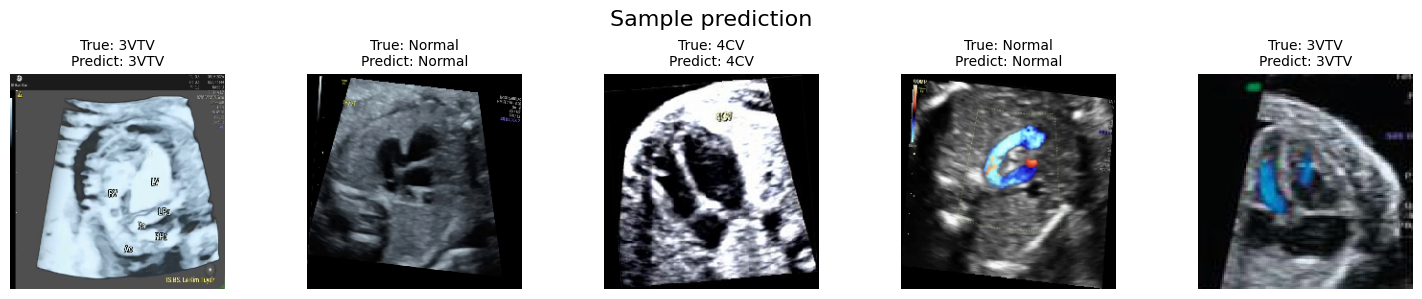

In [22]:
print(f"\n=======================================================")
print(f"Best Fold: {best_fold_index}\n Accuracy: {best_accuracy:.4f}")
print(f"=======================================================")

all_imgs = np.array(list(df[0])) / 255.0
all_labels = np.array(list(df[1]))
encoder = LabelEncoder()
encoder.fit(all_labels)
all_labels = encoder.transform(all_labels)
all_labels_one_hot = to_categorical(all_labels)

num_to_visualize = 5
random_indices = np.random.choice(len(all_imgs), num_to_visualize, replace=False)
random_test_imgs = all_imgs[random_indices]
random_test_labels = all_labels_one_hot[random_indices]

if best_model1 is not None and best_model2 is not None and best_model3 is not None:
    res1_new = best_model1.predict(random_test_imgs)
    res2_new = best_model2.predict(random_test_imgs)
    res3_new = best_model3.predict(random_test_imgs)
    predictedClass_new = doFusion(res1_new, res2_new, res3_new, random_test_labels, class_no=num_classes)
else:
    predictedClass_new = [0] * num_to_visualize

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle(f'Sample prediction', fontsize=16)

for j in range(num_to_visualize):
    true_index = random_indices[j]
    sample_image = all_imgs[true_index]
    true_label = target_names[all_labels[true_index]]
    predicted_label = target_names[predictedClass_new[j]]

    axes[j].imshow(sample_image)
    axes[j].set_title(f"True: {true_label}\nPredict: {predicted_label}", fontsize=10)
    axes[j].axis('off')

plt.tight_layout()
plt.show()